In [1]:
import numpy as np  

import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt  

import tensorflow as tf 
from tensorflow.keras.models import Sequential  

from tensorflow.keras.layers import LSTM, Dense 

from tensorflow.keras.optimizers import Adam 

from tensorflow.keras.callbacks import EarlyStopping  

from sklearn.preprocessing import StandardScaler 

from sklearn.metrics import mean_squared_error, mean_absolute_error  

from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Bidirectional  

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  

from tensorflow.keras.models import load_model 

2025-08-12 21:49:39.843841: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-12 21:49:39.850144: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-12 21:49:39.864955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755035379.893824    2270 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755035379.902961    2270 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755035379.922805    2270 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
appliances = ["dishwaser", "electric_heat", "microwave", "oven", "refrigerator", "stove", "washer_dryer"] 

mains = ["mains"] 

In [3]:
df = pd.read_csv('../../dataset/redd_combined/house_1.csv') 

df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s') 

df['Timestamp'] = df['Timestamp'].dt.tz_localize('UTC') 

df.set_index('Timestamp', inplace=True) 

data = df; 

print(data.isna().sum()) 

print(data.head()) 

print(data.tail()) 

mains              0
bathroom_gfi       0
dishwaser          0
electric_heat      0
kitchen_outlets    0
lighting           0
microwave          0
oven               0
refrigerator       0
stove              0
washer_dryer       0
dtype: int64
                            mains  bathroom_gfi  dishwaser  electric_heat  \
Timestamp                                                                   
2011-04-18 13:22:09+00:00  342.82           1.0        0.0            0.0   
2011-04-18 13:22:10+00:00  344.56           1.0        0.0            0.0   
2011-04-18 13:22:11+00:00  345.14           1.0        0.0            0.0   
2011-04-18 13:22:12+00:00  341.68           1.0        0.0            0.0   
2011-04-18 13:22:13+00:00  341.03           1.0        0.0            0.0   

                           kitchen_outlets  lighting  microwave  oven  \
Timestamp                                                               
2011-04-18 13:22:09+00:00             57.0     192.0        5.0   0.0 

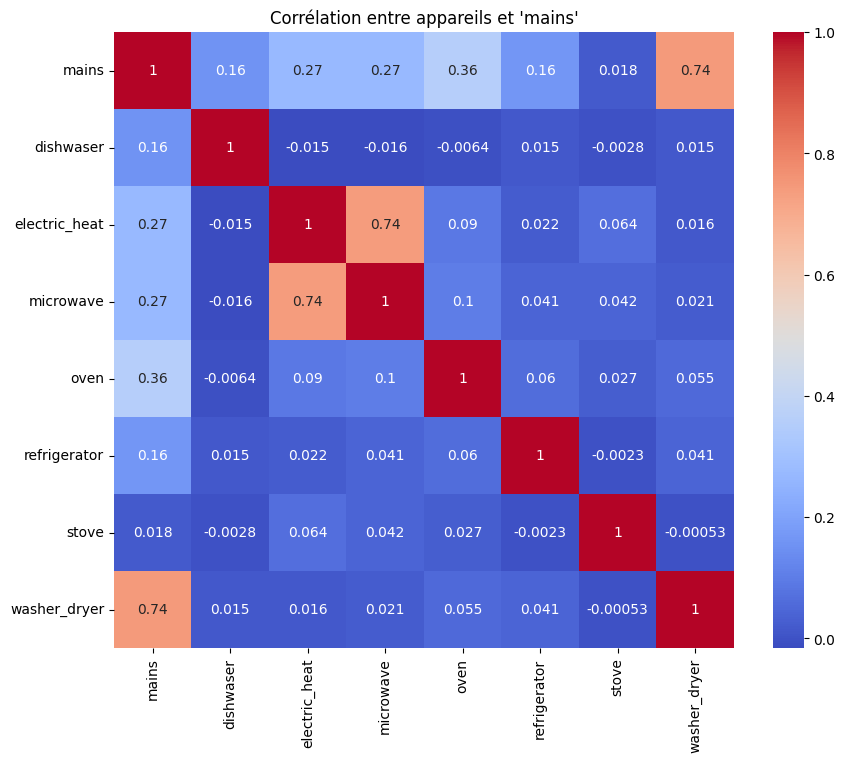

In [4]:
 
plt.figure(figsize=(10, 8)) 

corr = df[mains + appliances].corr() 

sns.heatmap(corr, annot=True, cmap="coolwarm") 

plt.title("Corrélation entre appareils et 'mains'") 

plt.show() 

 

 

In [5]:
total_energy = [data[m].values for m in mains] 

appliance_energy = [data[a].values for a in appliances] 

end_train = 3600 * 24 *30  

end_test = 3600* 24 *2 + end_train 

train_data = {m: e[:end_train] for m, e in zip(mains, total_energy)}  

test_data = {m: e[end_train:end_test] for m, e in zip(mains, total_energy)} 
train_appliance = {a: e[:end_train] for a, e in zip(appliances, appliance_energy)}
test_appliance = {a: e[end_train:end_test] for a, e in zip(appliances, appliance_energy)} 

 

In [6]:


scalers_total = {}
scalers_appliance = {}

# Ajustement des scalers pour le total (mains)
for m in mains:
    scalers_total[m] = StandardScaler().fit(train_data[m].reshape(-1, 1))

# Ajustement des scalers pour chaque appareil
for a in appliances:
    scalers_appliance[a] = StandardScaler().fit(train_appliance[a].reshape(-1, 1))

# Transformation des données d'entraînement
train_data = {
    m: scalers_total[m].transform(train_data[m].reshape(-1, 1))
    for m in mains
}
print(train_data)

# Transformation des données de test
test_data = {
    m: scalers_total[m].transform(test_data[m].reshape(-1, 1))
    for m in mains
}
print(test_data)

# Transformation des appliances d'entraînement
train_appliance = {
    a: scalers_appliance[a].transform(train_appliance[a].reshape(-1, 1))
    for a in appliances
}

# Transformation des appliances de test
test_appliance = {
    a: scalers_appliance[a].transform(test_appliance[a].reshape(-1, 1))
    for a in appliances
}


{'mains': array([[-0.11744597],
       [-0.11423112],
       [-0.1131595 ],
       ...,
       [-0.29788417],
       [-0.29888188],
       [-0.29696036]])}
{'mains': array([[-0.29786569],
       [-0.29792112],
       [-0.29581484],
       ...,
       [-0.3004154 ],
       [-0.30035997],
       [-0.29732988]])}


In [7]:
import numpy as np

def create_sequences(mains_data, appliances_data, seq_length):
    X = []
    y = []

    # Création des séquences pour les données "mains"
    for i in range(len(mains_data[mains[0]]) - seq_length):
        tempI = []
        for j in range(i, i + seq_length):
            tempJ = []
            for k in range(len(mains)):
                tempJ.append(mains_data[mains[k]][j][0])
            tempI.append(tempJ)
        X.append(tempI)

    # Création des séquences pour les données "appliances"
    for i in range(len(appliances_data[appliances[0]]) - seq_length):
        tempI = []
        for k in range(len(appliances)):
            tempI.append(appliances_data[appliances[k]][i][0])
        y.append(tempI)

    return np.array(X), np.array(y)


In [8]:


# Longueur des séquences
seq_length = 10

# Création des séquences
X_train, y_train = create_sequences(train_data, train_appliance, seq_length)
X_test, y_test = create_sequences(test_data, test_appliance, seq_length)

# Reshape des données d'entrée
X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], len(mains)))
X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], len(mains)))

print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)

# Création du modèle avec 2 LSTM empilés
model = Sequential()

model.add(Input(shape=(seq_length, len(mains))))
model.add(LSTM(64, return_sequences=True))  # conserve la séquence pour le LSTM suivant
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(32, activation='tanh'))  # ici, sortie finale des séquences
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(len(appliances)))  # sortie finale

# Compilation du modèle
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='mae',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Entraînement
history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)


Shape X_train: (86390, 10, 1)
Shape y_train: (86390, 7)


2025-08-12 21:49:50.549652: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/80
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.2591 - loss: 0.5642 - val_accuracy: 0.7565 - val_loss: 0.1741
Epoch 2/80
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.4791 - loss: 0.2770 - val_accuracy: 0.7437 - val_loss: 0.1451
Epoch 3/80
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.6519 - loss: 0.2264 - val_accuracy: 0.9577 - val_loss: 0.1201
Epoch 4/80
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7307 - loss: 0.2029 - val_accuracy: 0.9579 - val_loss: 0.1051
Epoch 5/80
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7339 - loss: 0.1920 - val_accuracy: 0.9579 - val_loss: 0.1033
Epoch 6/80
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.7340 - loss: 0.1888 - val_accuracy: 0.9585 - val_loss: 0.1084
Epoch 7/80
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7492 - loss: 0.1818 - val_accuracy: 0.9585 - val_loss: 0.0963
Epoch 8/80
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.7528 -

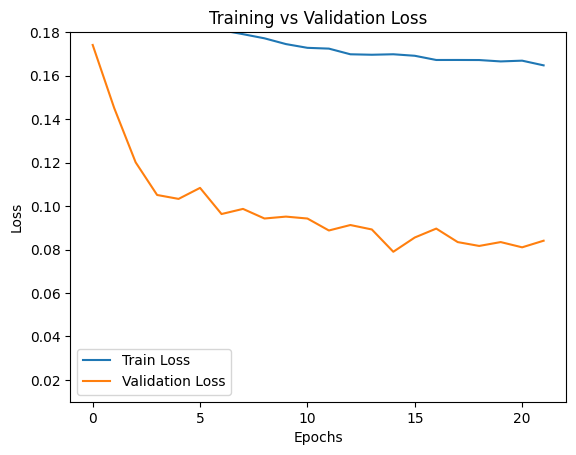

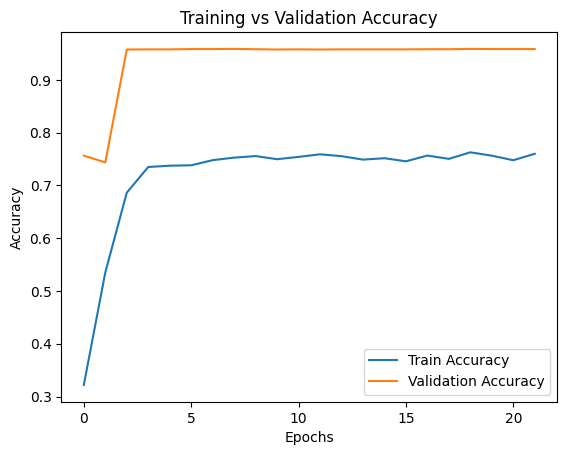

In [13]:
plt.plot(history.history['loss'], label='Train Loss')  

plt.plot(history.history['val_loss'], label='Validation Loss')  

plt.xlabel('Epochs') 
plt.ylim(0.01, 0.18) 

plt.ylabel('Loss') 

plt.title('Training vs Validation Loss')  

plt.legend()  

plt.show() 
plt.plot(history.history['accuracy'], label='Train Accuracy') 
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') 

plt.xlabel('Epochs')  

plt.ylabel('Accuracy')  

plt.title('Training vs Validation Accuracy') 

plt.legend() 
plt.show() 

In [15]:
best_model = load_model('best_model.keras')  

predicted = model.predict(X_test)  

true = np.zeros_like(y_test)  

pred = np.zeros_like(predicted)  

for j, a in enumerate(appliances):  

    scaler = scalers_appliance[a]  

    true[:, j:j+1] = scaler.inverse_transform(y_test[:, j:j+1])  

    pred[:, j:j+1] = scaler.inverse_transform(predicted[:, j:j+1]) 

 

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


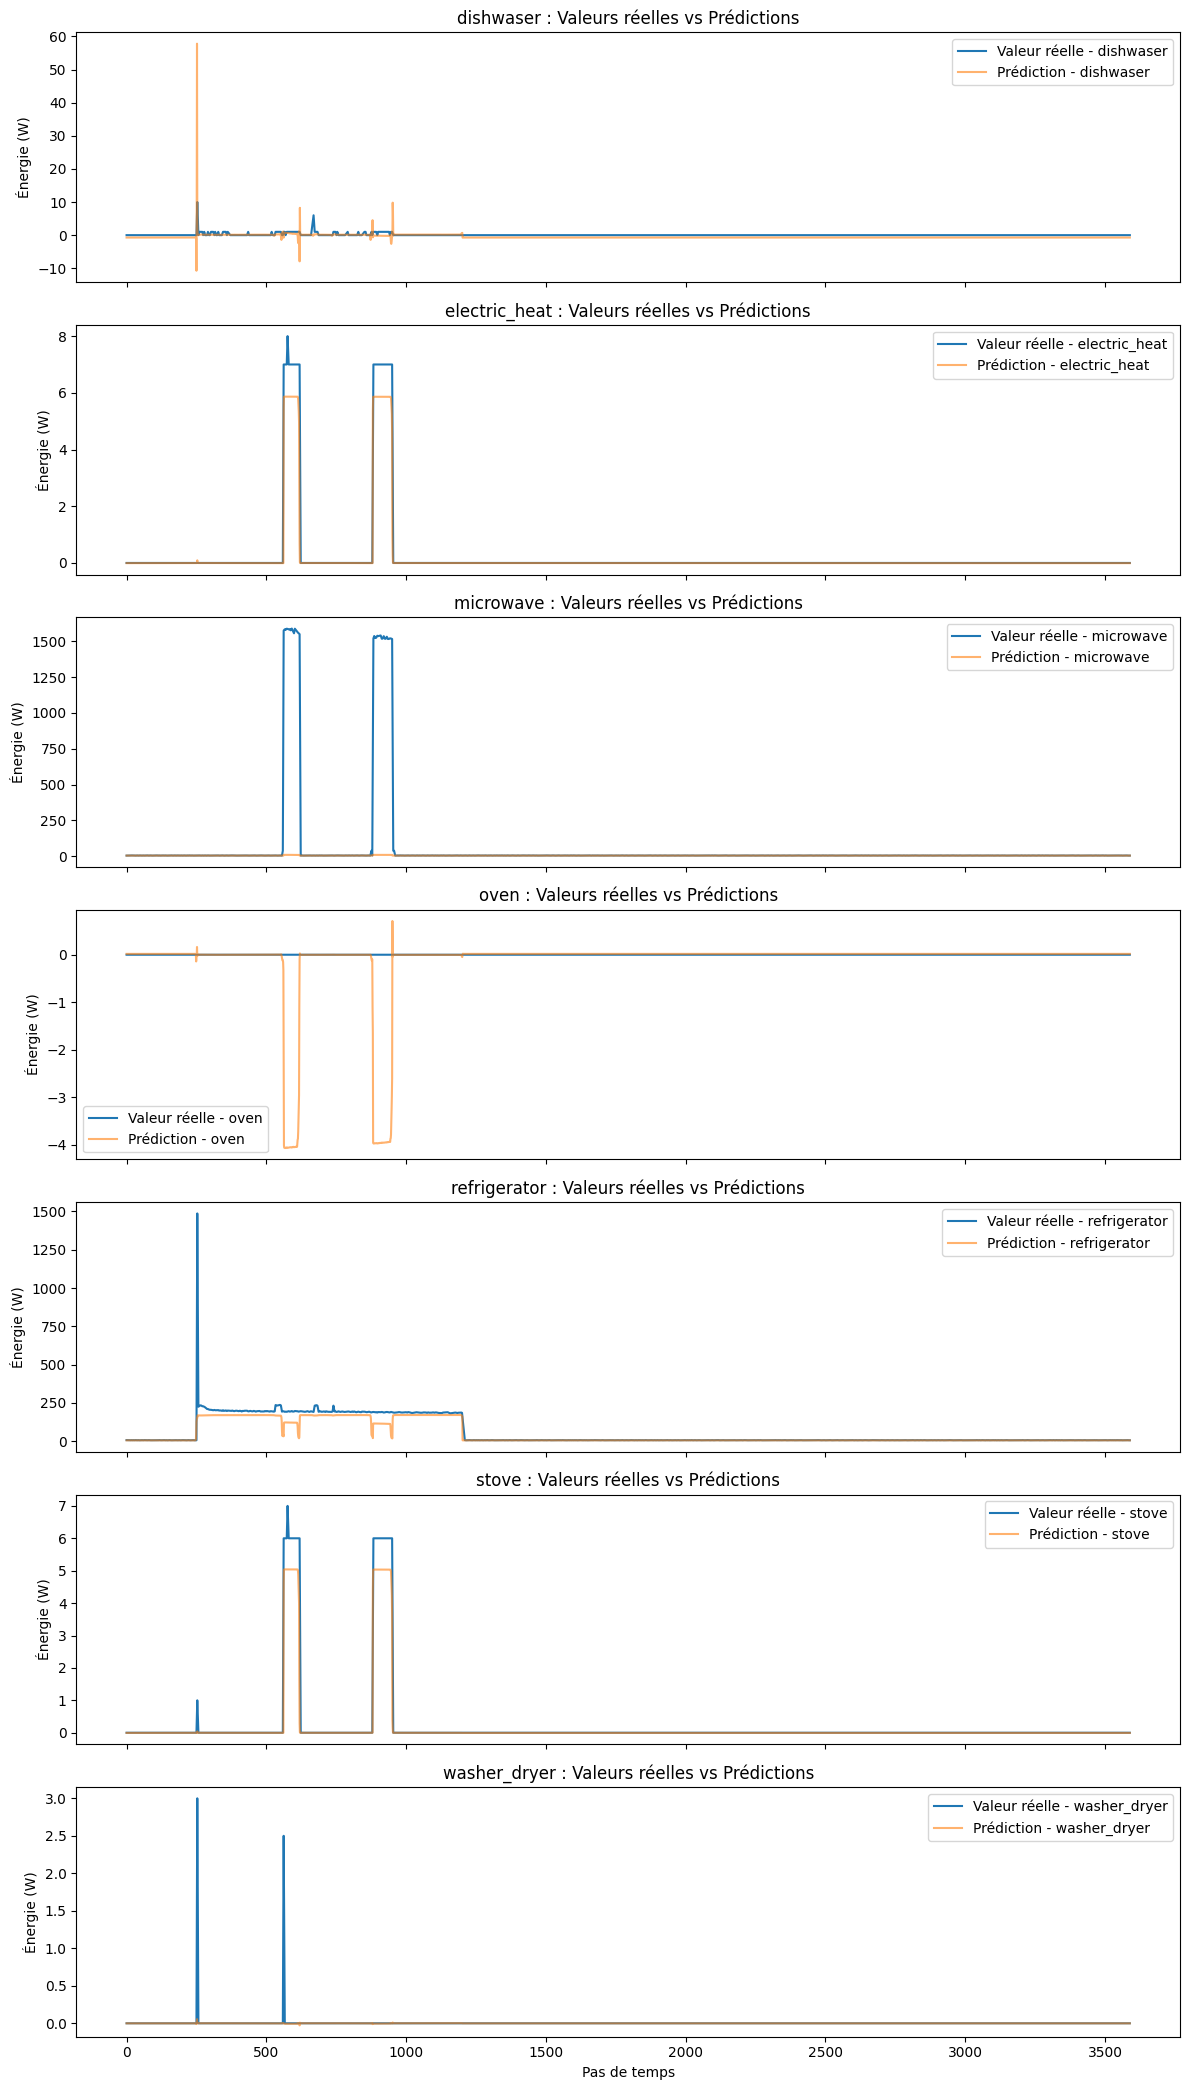

In [18]:
n_appliances = len(appliances)

# Créer les sous-graphiques
fig, axes = plt.subplots(n_appliances, 1, figsize=(12, 3 * n_appliances), sharex=True)

# Si une seule appliance, mettre axes dans une liste
if n_appliances == 1:
    axes = [axes]

# Boucle sur chaque appareil
for i, a in enumerate(appliances):
    axes[i].plot(true[:, i], label=f'Valeur réelle - {a}')
    axes[i].plot(pred[:, i], label=f'Prédiction - {a}', alpha=0.6)
    axes[i].legend()
    axes[i].set_title(f'{a} : Valeurs réelles vs Prédictions')
    axes[i].set_ylabel('Énergie (W)')

# Label pour l’axe X seulement sur le dernier subplot
axes[-1].set_xlabel('Pas de temps')

# Ajustement des espacements
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()

# Afficher le graphique
plt.show()


In [ ]:
for i, a in enumerate(appliances):
    mae = mean_absolute_error(true[:, i], pred[:, i]) 
    mse = mean_squared_error(true[:, i], pred[:, i]) 
    rmse = np.sqrt(mse)
    print(f"{a}: MAE = {mae:.4f}, RMSE = {rmse:.4f}, MSE = {mse:.4f}") 

dishwaser: MAE = 0.6700, RMSE = 1.1789, MSE = 1.3898
electric_heat: MAE = 0.0585, RMSE = 0.3138, MSE = 0.0985
microwave: MAE = 56.8272, RMSE = 292.0982, MSE = 85321.3635
oven: MAE = 0.1521, RMSE = 0.7362, MSE = 0.5421
refrigerator: MAE = 11.3622, RMSE = 41.7926, MSE = 1746.6196
stove: MAE = 0.0513, RMSE = 0.2782, MSE = 0.0774
washer_dryer: MAE = 0.0060, RMSE = 0.1013, MSE = 0.0103
